# Midterm Project

> Develop classification models to predict a target variable.
> Evaluate the classification models based on the different performance metrics.

[Link to Dataset](https://www.kaggle.com/datasets/adeniranstephen/obesity-prediction-dataset)

In [41]:
# Import dataset
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
import matplotlib.pyplot as plt

raw = pd.read_csv('data/obesity_dataset.csv')

raw = raw.sample(frac=1).reset_index(drop=True)

raw

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,21,1.68,75.00,yes,yes,2.00,3.00,Sometimes,no,1.16,no,1.00,0.000,Sometimes,Public_Transportation,Overweight_Level_I
1,Male,29,1.77,108.60,yes,yes,3.00,3.00,Sometimes,no,1.16,no,1.87,1.605,Sometimes,Automobile,Obesity_Type_I
2,Male,25,1.76,117.30,yes,yes,1.39,3.00,Sometimes,no,2.00,no,1.10,0.631,Sometimes,Public_Transportation,Obesity_Type_II
3,Male,18,1.65,85.00,no,yes,2.00,3.00,Sometimes,no,1.00,no,1.00,0.000,Sometimes,Public_Transportation,Obesity_Type_I
4,Male,18,1.82,108.40,yes,yes,2.00,2.16,Sometimes,no,2.09,no,1.00,0.677,Sometimes,Public_Transportation,Obesity_Type_I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,19,1.80,138.03,yes,yes,3.00,3.00,Sometimes,no,2.69,no,1.17,0.735,Sometimes,Public_Transportation,Obesity_Type_III
2107,Male,26,1.70,70.00,yes,no,3.00,1.00,Frequently,no,2.00,no,2.00,0.000,Frequently,Public_Transportation,Normal_Weight
2108,Female,25,1.57,64.85,yes,no,2.00,1.00,Sometimes,no,1.00,no,0.74,0.000,no,Public_Transportation,Overweight_Level_II
2109,Female,16,1.82,47.12,no,yes,3.00,3.29,Sometimes,no,2.15,no,2.46,1.273,Sometimes,Public_Transportation,Insufficient_Weight


### Data Cleaning

1. CALC, CAEC Column must only have the values [Never, Sometimes, Frequently, Always]
2. Change underscores to whitespace
3. Apply One Hot Encoding for Categorical Values
4. Apply Standard Scaler for Numeric Values
5. Apply K-Bins Discretizer for Numeric Values (Categorical Naive Bayes)

In [42]:
# Cleanup CALC and CAEC [Transform no to Never]
raw['CALC'] = raw['CALC'].replace("no", "Never")
raw['CAEC'] = raw['CAEC'].replace("no", "Never")

# Change underscore values to whitespace and standardized
# Replace underscores in COLUMN NAMES (if they exist)
raw.columns = raw.columns.str.replace('_', ' ')

# Apply title case ONLY to column names containing spaces (multi-word columns)
raw.columns = [
    col.title() if ' ' in col else col  # Title case only if space exists
    for col in raw.columns
]

# Replace underscores in DATA ROWS for specific columns
for col in ['MTRANS', 'NObeyesdad']:
    raw[col] = raw[col].astype(str).str.replace('_', ' ', regex=True)

# Columns to standardize to title case
title_case_columns = [
    'Family History With Overweight',  # After underscore replacement
    'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC'
]

# Convert values in these columns to title case
raw[title_case_columns] = raw[title_case_columns].apply(lambda x: x.astype(str).str.title())
# Split data into categorical and numeric
categorical_cols = [
    'Gender', 'Family History With Overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS'
]
numerical_cols = [
    'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'
]

# Create Preprocessor
cnb_preprocessor = ColumnTransformer(
    transformers=[
        ('num', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'), numerical_cols),
        # Discretize numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # Encode categoricals
    ]
)
svm_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # Encode categoricals
    ]
)

### Prepare Data

1. Split features and target column
2. Prepare training and testing data.

In [43]:
# Split the dataset (unseen = 90% of dataset), (data = 10% of dataset)
unseen = raw.iloc[1900:2110].reset_index(drop=True)  # Get unseen sample
data = raw.iloc[0:1899].reset_index(drop=True)  # Cut original dataset

# Split Features and Target Column
features = data.drop('NObeyesdad', axis=1).copy()
target_col = data['NObeyesdad'].copy()

features_train, features_test, target_train, target_test = train_test_split(
    features, target_col, test_size=0.2
)

### Train Categorical Naive Bayes Model

In [44]:
cnb_model = Pipeline([
    ('preprocessor', cnb_preprocessor),
    ('classifier', CategoricalNB())
])

cnb_model.fit(features_train, target_train)

cnb_pred_train = cnb_model.predict(features_train)
cnb_pred_test = cnb_model.predict(features_test)

### Train Support Vector Machine Model

In [45]:
svm_model = Pipeline([
    ('preprocessor', svm_preprocessor),
    ('classifier', SVC(
        C=1.0,
        gamma='scale',
        probability=True,
        class_weight='balanced'  # Handles class imbalance
    ))
])

svm_model.fit(features_train, target_train)

svm_pred_train = svm_model.predict(features_train)
svm_pred_test = svm_model.predict(features_test)

### Train Random Forest Classifier Model

In [46]:
from sklearn.ensemble import RandomForestClassifier

rfc_model = Pipeline([
    ('preprocessor', svm_preprocessor),
    ('classifier', RandomForestClassifier(
        class_weight='balanced'  # Handle class imbalance
    ))
])

rfc_model.fit(features_train, target_train)

rfc_pred_train = rfc_model.predict(features_train)
rfc_pred_test = rfc_model.predict(features_test)

### Display Confusion Matrices for every model

In [47]:
import seaborn as sns

# Prepare Matrices
cnb_confmtrx = confusion_matrix(target_train, cnb_model.predict(features_train))
svm_confmtrx = confusion_matrix(target_train, svm_model.predict(features_train))
rfc_confmtrx = confusion_matrix(target_train, rfc_model.predict(features_train))
labels = ['Obesity Type I','Obesity Type III','Obesity Type II','Overweight Level II','Overweight Level I','Normal Weight','Insufficient Weight']

<Axes: >

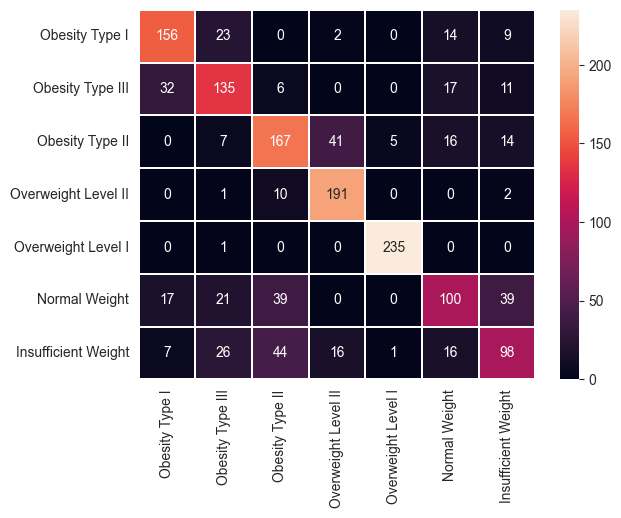

In [48]:
sns.heatmap(cnb_confmtrx, annot=True, linewidths = 0.01 ,xticklabels=labels, yticklabels=labels, fmt='d')

<Axes: >

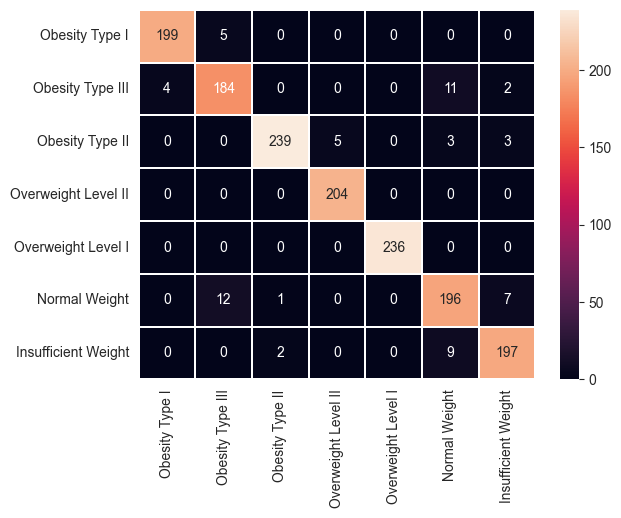

In [49]:
sns.heatmap(svm_confmtrx, annot=True, linewidths = 0.01 ,xticklabels=labels, yticklabels=labels, fmt='d')

<Axes: >

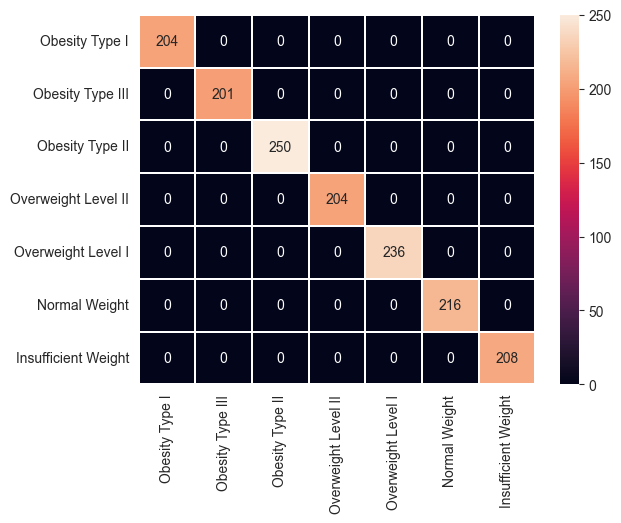

In [50]:
sns.heatmap(rfc_confmtrx, annot=True, linewidths = 0.01 ,xticklabels=labels, yticklabels=labels, fmt='d')

### Get Accuracy, Precision, Recall, and ROC-AUC Scores for all Models
The mean value of every result from the Ten-Fold Validation is displayed

In [51]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
apr_results = pd.DataFrame({
    'Results': ['Categorical Naive Bayes', 'Support Vector Machine', 'Random Forest Classifier'],
    'Testing Accuracy': [cross_val_score(cnb_model, features_test, target_test, cv=cv, scoring='accuracy').mean(),
                         cross_val_score(svm_model, features_test, target_test, cv=cv, scoring='accuracy').mean(),
                         cross_val_score(rfc_model, features_test, target_test, cv=cv, scoring='accuracy').mean()],
    'Testing Precision': [
        cross_val_score(cnb_model, features_test, target_test, cv=cv, scoring='precision_weighted').mean(),
        cross_val_score(svm_model, features_test, target_test, cv=cv, scoring='precision_weighted').mean(),
        cross_val_score(rfc_model, features_test, target_test, cv=cv, scoring='precision_weighted').mean()],
    'Testing Recall': [cross_val_score(cnb_model, features_test, target_test, cv=cv, scoring='recall_weighted').mean(),
                       cross_val_score(svm_model, features_test, target_test, cv=cv, scoring='recall_weighted').mean(),
                       cross_val_score(rfc_model, features_test, target_test, cv=cv, scoring='recall_weighted').mean()],
    'Testing ROC-AUC': [cross_val_score(cnb_model, features_test, target_test, cv=cv, scoring='roc_auc_ovr').mean(),
                        cross_val_score(svm_model, features_test, target_test, cv=cv, scoring='roc_auc_ovr').mean(),
                        cross_val_score(rfc_model, features_test, target_test, cv=cv, scoring='roc_auc_ovr').mean()],
    'Training Accuracy': [cross_val_score(cnb_model, features_train, target_train, cv=cv, scoring='accuracy').mean(),
                          cross_val_score(svm_model, features_train, target_train, cv=cv, scoring='accuracy').mean(),
                          cross_val_score(rfc_model, features_train, target_train, cv=cv, scoring='accuracy').mean()],
    'Training Precision': [
        cross_val_score(cnb_model, features_train, target_train, cv=cv, scoring='precision_weighted').mean(),
        cross_val_score(svm_model, features_train, target_train, cv=cv, scoring='precision_weighted').mean(),
        cross_val_score(rfc_model, features_train, target_train, cv=cv, scoring='precision_weighted').mean()],
    'Training Recall': [
        cross_val_score(cnb_model, features_train, target_train, cv=cv, scoring='recall_weighted').mean(),
        cross_val_score(svm_model, features_train, target_train, cv=cv, scoring='recall_weighted').mean(),
        cross_val_score(rfc_model, features_train, target_train, cv=cv, scoring='recall_weighted').mean()],
    'Training ROC-AUC': [cross_val_score(cnb_model, features_train, target_train, cv=cv, scoring='roc_auc_ovr').mean(),
                         cross_val_score(svm_model, features_train, target_train, cv=cv, scoring='roc_auc_ovr').mean(),
                         cross_val_score(rfc_model, features_train, target_train, cv=cv, scoring='roc_auc_ovr').mean()]
})

apr_results

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Results,Testing Accuracy,Testing Precision,Testing Recall,Testing ROC-AUC,Training Accuracy,Training Precision,Training Recall,Training ROC-AUC
0,Categorical Naive Bayes,0.655263,0.669708,0.655263,0.916751,0.690572,0.682296,0.690572,0.933906
1,Support Vector Machine,0.721053,0.739191,0.721053,0.955715,0.909790,0.914031,0.909790,0.992323
2,Random Forest Classifier,0.826316,0.861743,0.834211,0.977342,0.943391,0.942362,0.932189,0.994676


### Test models using the unseen dataset

In [52]:
expected = unseen['NObeyesdad'].copy()

# Categorical Naive Bayes
cnb_unseen = unseen.copy()
cnb_unseen.drop('NObeyesdad', axis=1, inplace=True)
cnb_unseen['Predictions'] = cnb_model.predict(cnb_unseen)
cnb_comparison = pd.DataFrame({
    'Expected': expected,
    'Actual': cnb_unseen['Predictions'],
})

# Support Vector Model
svm_unseen = unseen.copy()
svm_unseen.drop('NObeyesdad', axis=1, inplace=True)
svm_unseen['Predictions'] = svm_model.predict(svm_unseen)
svm_comparison = pd.DataFrame({
    'Expected': expected,
    'Actual': svm_unseen['Predictions'],
})

# Support Vector Model
rfc_unseen = unseen.copy()
rfc_unseen.drop('NObeyesdad', axis=1, inplace=True)
rfc_unseen['Predictions'] = rfc_model.predict(rfc_unseen)
rfc_comparison = pd.DataFrame({
    'Expected': expected,
    'Actual': rfc_unseen['Predictions'],
})

# Match Counter
def match_count(df):
    col1, col2 = df.columns
    matches = (df[col1] == df[col2]).sum()
    mismatches = len(df) - matches
    return [matches, mismatches]

In [53]:
matches = match_count(cnb_comparison)
print("Categorical Naive Bayes Test")
print('Matches: ', matches[0], ' | Mismatches: ', matches[1])
cnb_comparison

Categorical Naive Bayes Test
Matches:  159  | Mismatches:  51


,Expected,Actual
0,Insufficient Weight,Insufficient Weight
1,Obesity Type III,Obesity Type III
2,Obesity Type III,Obesity Type III
3,Overweight Level II,Normal Weight
4,Obesity Type III,Obesity Type III
...,...,...
205,Obesity Type II,Obesity Type II
206,Obesity Type III,Obesity Type III
207,Normal Weight,Normal Weight
208,Overweight Level II,Normal Weight


In [54]:
matches = match_count(svm_comparison)
print("Support Vector Machine Test")
print('Matches: ', matches[0], ' | Mismatches: ', matches[1])
svm_comparison

Support Vector Machine Test
Matches:  195  | Mismatches:  15


,Expected,Actual
0,Insufficient Weight,Insufficient Weight
1,Obesity Type III,Obesity Type III
2,Obesity Type III,Obesity Type III
3,Overweight Level II,Overweight Level II
4,Obesity Type III,Obesity Type III
...,...,...
205,Obesity Type II,Obesity Type II
206,Obesity Type III,Obesity Type III
207,Normal Weight,Normal Weight
208,Overweight Level II,Overweight Level II


In [55]:
matches = match_count(rfc_comparison)
print("Random Forest Classifier")
print('Matches: ', matches[0], ' | Mismatches: ', matches[1])
rfc_comparison

Random Forest Classifier
Matches:  199  | Mismatches:  11


,Expected,Actual
0,Insufficient Weight,Insufficient Weight
1,Obesity Type III,Obesity Type III
2,Obesity Type III,Obesity Type III
3,Overweight Level II,Overweight Level II
4,Obesity Type III,Obesity Type III
...,...,...
205,Obesity Type II,Obesity Type II
206,Obesity Type III,Obesity Type III
207,Normal Weight,Normal Weight
208,Overweight Level II,Overweight Level II


### Decision tree

Decision Tree Accuracy: 0.7157894736842105
Classification Report:
                      precision    recall  f1-score   support

Insufficient Weight       0.73      0.86      0.79        44
      Normal Weight       0.63      0.63      0.63        62
     Obesity Type I       0.72      0.89      0.79        70
    Obesity Type II       0.81      0.85      0.83        54
   Obesity Type III       0.98      1.00      0.99        46
 Overweight Level I       0.43      0.52      0.47        46
Overweight Level II       0.85      0.29      0.44        58

           accuracy                           0.72       380
          macro avg       0.74      0.72      0.71       380
       weighted avg       0.73      0.72      0.70       380



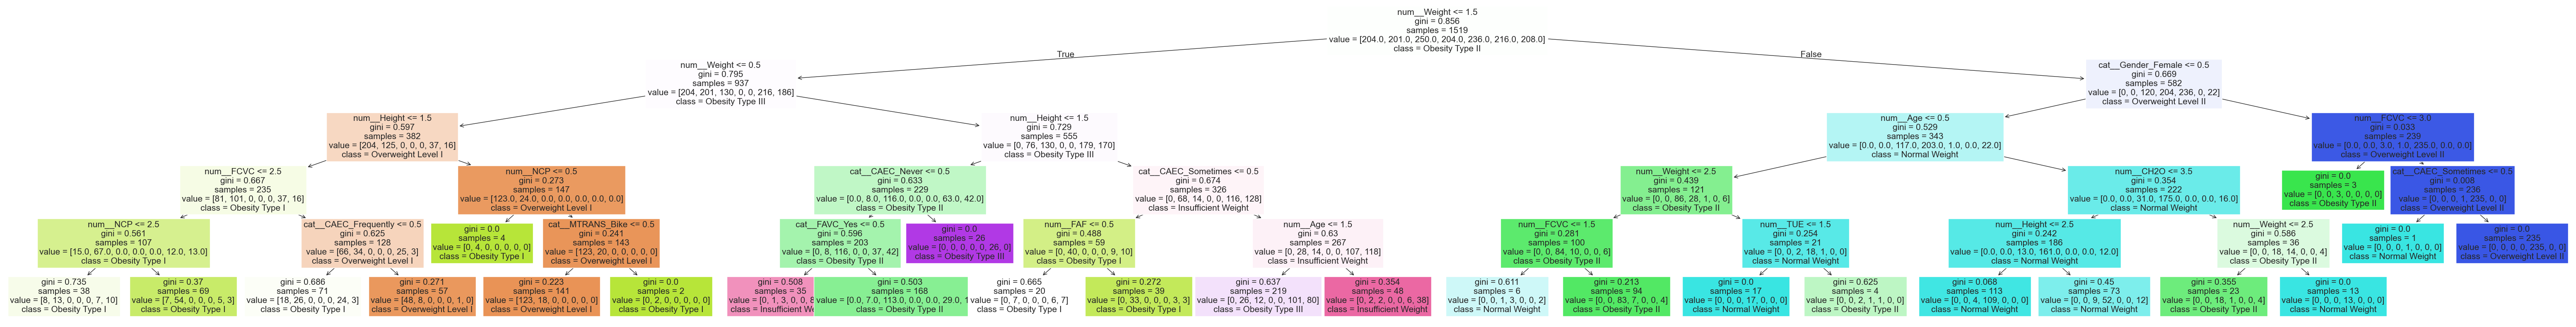

In [56]:
# Preprocessing pipeline
cnb_preprocessor = ColumnTransformer(
    transformers=[
        ('num', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Decision Tree pipeline
dt_pipeline = Pipeline([
    ('preprocessor', cnb_preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, max_depth=5))
])

# Fit the pipeline
dt_pipeline.fit(features_train, target_train)

# Get feature names after preprocessing
feature_names = cnb_preprocessor.get_feature_names_out()

# Evaluate the model
dt_predictions = dt_pipeline.predict(features_test)
print("Decision Tree Accuracy:", accuracy_score(target_test, dt_predictions))
print("Classification Report:\n", classification_report(target_test, dt_predictions))

# Visualize the decision tree
plt.figure(figsize=(80, 10))
plot_tree(
    dt_pipeline.named_steps['classifier'],
    filled=True,
    feature_names=feature_names,  # Use the correct feature names
    class_names=target_col.unique(),  # Use the unique class names
    fontsize=15,  # Adjust font size for better readability

)
plt.show()

### Rule-based Classifier

RuleFit Accuracy: 0.8
Classification Report:
                      precision    recall  f1-score   support

Insufficient Weight       0.93      0.91      0.92        44
      Normal Weight       0.86      0.92      0.89        62
     Obesity Type I       0.74      0.57      0.65        70
    Obesity Type II       0.64      0.98      0.77        54
   Obesity Type III       0.96      1.00      0.98        46
 Overweight Level I       0.73      0.78      0.76        46
Overweight Level II       0.86      0.55      0.67        58

           accuracy                           0.80       380
          macro avg       0.82      0.82      0.81       380
       weighted avg       0.81      0.80      0.79       380

Top Rules:
                                                   rule  importance
3                                            feature_3    1.725765
1                                            feature_1    1.589435
76   Weight <= -1.1964925527572632 & Height > -0.55...    1.420410


C:\Users\Admin\AppData\Local\Temp\ipykernel_19404\3011423244.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='rule', data=top_rules, palette='viridis')


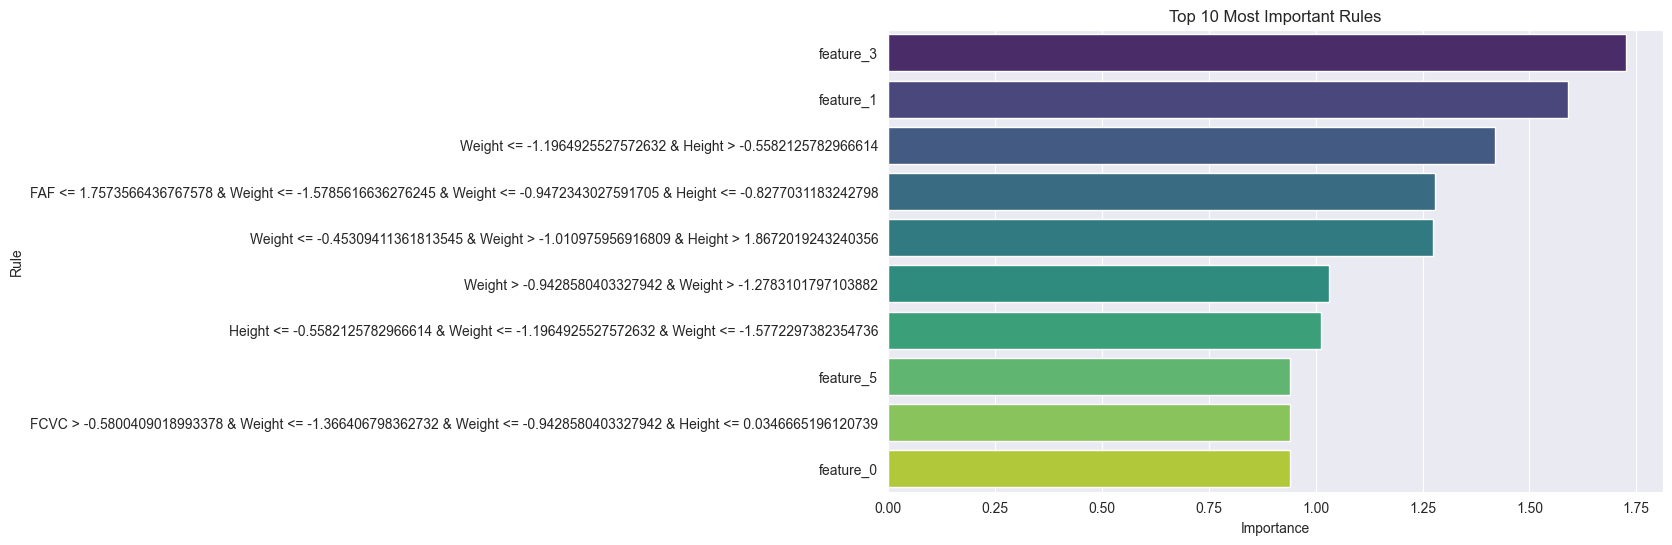

In [58]:
import re
from rulefit import RuleFit
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
label_encoder = LabelEncoder()
target_train_encoded = label_encoder.fit_transform(target_train)
target_test_encoded = label_encoder.transform(target_test)

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # Encode categorical features
    ]
)

# Create the RuleFit pipeline
rulefit_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Apply preprocessing
    ('classifier', RuleFit(
        random_state=42,
        tree_size=4,  # Reduce tree size for simpler rules
        lin_standardise=True,  # Standardize linear features
        max_rules=200,  # Limit the number of rules
        rfmode='classify'  # Use classification mode
    ))
])

# Train the RuleFit model
rulefit_pipeline.fit(features_train, target_train_encoded)

# Make predictions
rulefit_predictions_encoded = rulefit_pipeline.predict(features_test)

# Decode the predictions back to original labels
rulefit_predictions = label_encoder.inverse_transform(rulefit_predictions_encoded)

# Evaluate the model
print("RuleFit Accuracy:", accuracy_score(target_test, rulefit_predictions))
print("Classification Report:\n", classification_report(target_test, rulefit_predictions))

# Extract and display the rules
rules = rulefit_pipeline.named_steps['classifier'].get_rules()
rules = rules[rules.coef != 0].sort_values("importance", ascending=False)

def map_feature_names(rules, preprocessor):
    feature_names = []

    # Get feature names from numerical columns
    numerical_features = preprocessor.named_transformers_['num'].get_feature_names_out(numerical_cols)

    # Get feature names from categorical columns
    categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)

    # Combine all feature names
    feature_names = numerical_features.tolist() + categorical_features.tolist()

    # Replace feature indices with actual names in the rules
    def replace_feature_indices(rule):
        parts = rule.split(' & ')
        new_parts = []
        for part in parts:
            try:
                # Split the part into feature index and condition
                feature_part, condition = part.split(' ', 1)
                feature_index = int(feature_part.split('_')[1])
                feature_name = feature_names[feature_index]
                new_parts.append(f"{feature_name} {condition}")
            except (ValueError, IndexError):
                # If the part cannot be split or parsed, keep it as is
                new_parts.append(part)
        return ' & '.join(new_parts)

    rules['rule'] = rules['rule'].apply(replace_feature_indices)
    return rules

# Apply the mapping function
rules = map_feature_names(rules, rulefit_pipeline.named_steps['preprocessor'])

print("Top Rules:\n", rules[['rule', 'importance']])

# Extract the top 10 most important rules
top_rules = rules.head(10)

# Plot rule importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='rule', data=top_rules, palette='viridis')
plt.title('Top 10 Most Important Rules')
plt.xlabel('Importance')
plt.ylabel('Rule')
plt.show()

